In [8]:
# Install missing package(s) in the notebook environment
%pip install seaborn yfinance statsmodels --quiet

# Import the necessary libraries to perform data test
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
#plt.style.use('seaborn-darkgrid')

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Load the dataset
data = yf.download('AAPL', start='2010-01-01', end=datetime.now().strftime('%Y-%m-%d'))
data = data['Close']

/var/folders/lh/22w5zzfn4fs82mm7hp75c_0r0000gn/T/ipykernel_13771/2294824273.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2010-01-01', end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


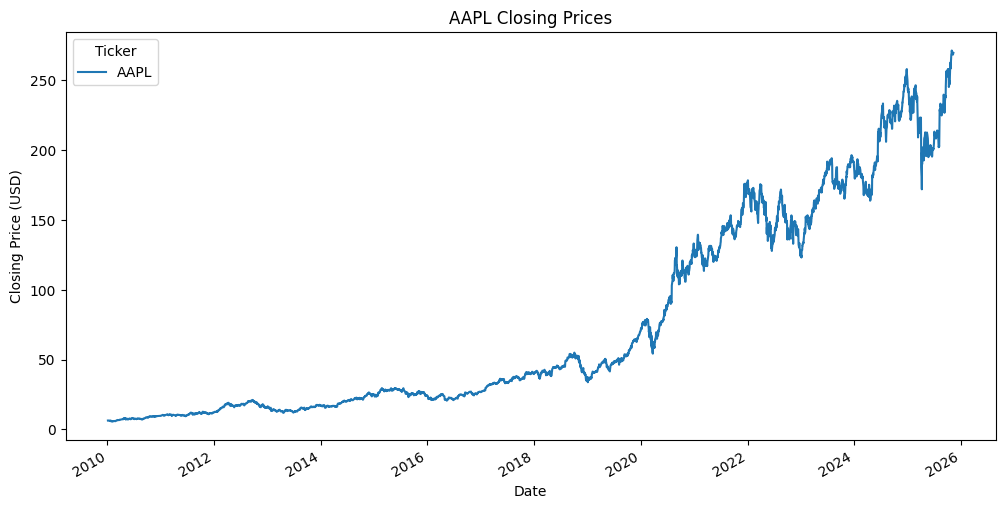

In [11]:
# Visualize the data
data.plot(title='AAPL Closing Prices', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()

In [12]:
# Check for stationarity using Augmented Dickey-Fuller test
result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value)) 

ADF Statistic: 1.406951347317209
p-value: 0.9971454930884299
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


In [13]:
# Create differenced series to achieve stationarity
data_diff = data.diff().dropna()
# Re-check for stationarity
result_diff = adfuller(data_diff)
print('\nAfter Differencing:')
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))
# Fit ARIMA model
model = ARIMA(data, order=(5, 1, 0))  # p=5, d=1, q=0
model_fit = model.fit()
print(model_fit.summary())


After Differencing:
ADF Statistic: -11.13655127984159
p-value: 3.1847175657255066e-20
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 3989
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8127.677
Date:                Wed, 12 Nov 2025   AIC                          16267.354
Time:                        18:31:21   BIC                          16305.101
Sample:                             0   HQIC                         16280.736
                               - 3989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.006      2.887      0.004       0.006       0.029
ar.L2          0.0218      0.008      2.718      0.007       0.006       0.037
ar.L3         -0.0437      0.008     -5.603      0.0

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


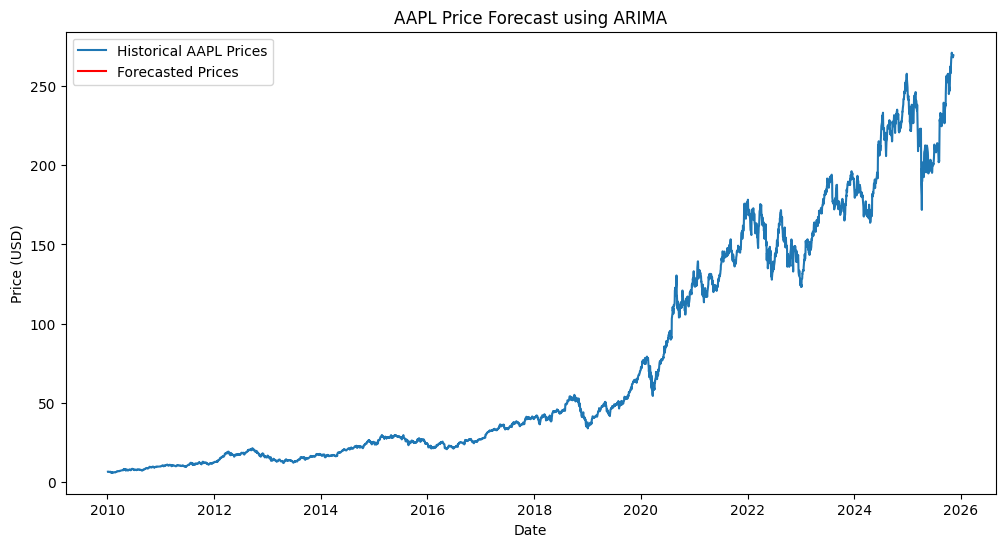

In [14]:
# Moving average forecast
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_series = pd.Series(forecast, index=forecast_index)
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical AAPL Prices')
plt.plot(forecast_series, label='Forecasted Prices', color='red')
plt.title('AAPL Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

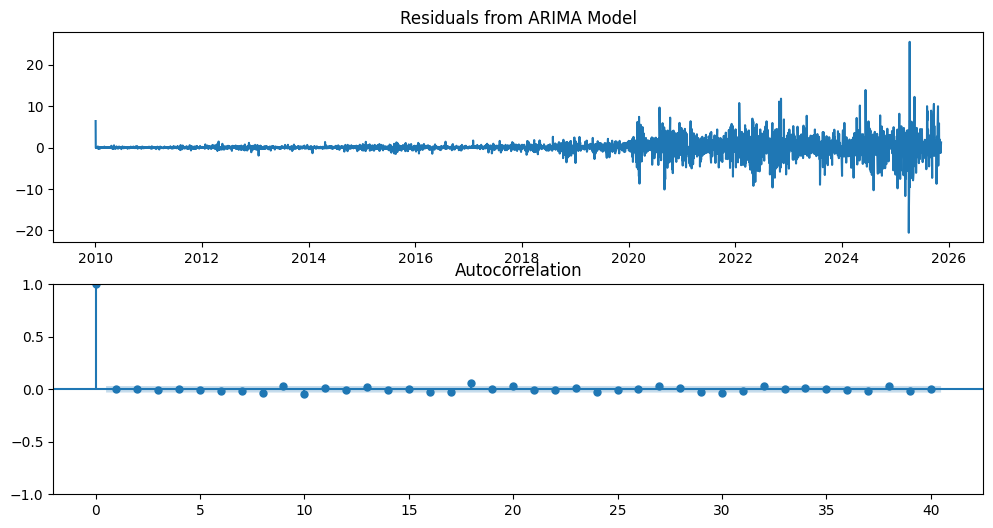

In [15]:
# Visualize residuals
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.show()